In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr

In [2]:
from io import StringIO
import numpy as np
import xarray as xr

def make_ds(filename, n1 = 731, n2 = 250):
    ''' Read in output and turn into 2D field.
        n1: number of time steps
        n2: number of depth points '''
    with open(filename, 'r') as file:
        lines = file.readlines()
        
    # Exclude the last two lines
    lines_to_keep = lines[:-2]
    # Join valid lines into a single string with newline characters
    valid_data = "\n".join(lines_to_keep)
    df = pd.read_csv(StringIO(valid_data), sep='\s+', header=None, names=['t','z','ux','uy','T','S','nn','nu'])
    
    # By default, reshape uses row-major (C-style) order, meaning it fills the array row by row.

    time = df['t'][::n2]/3600. # output is every 12 hrs (from second to hour)
    depth = df['z'][:n2] # depth are 1 m apart

    ux_2D = np.reshape(df['ux'],(n1,n2))
    uy_2D = np.reshape(df['uy'],(n1,n2))
    T = np.reshape(df['T'],(n1,n2))
    S = np.reshape(df['S'],(n1,n2))

    xrdf = xr.Dataset(
        {'ux': (['t','z'], ux_2D),
        'uy': (['t','z'], uy_2D),
        'T': (['t','z'], T),
        'S': (['t','z'], S)},
        coords={
            "t": time,
            "z": depth
        },)
    
    return xrdf

Text(0.5, 1.0, 'KPP minus $k-\\epsilon$')

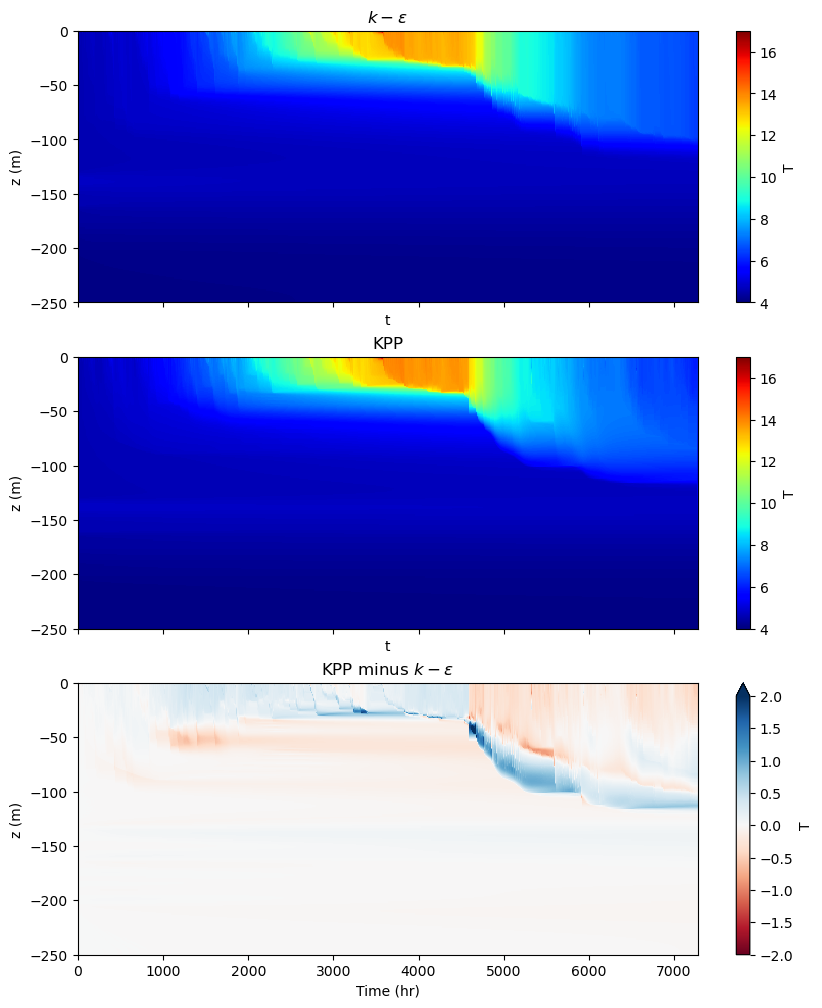

In [5]:
# xrdf['ux'].plot.pcolormesh(x='t',y='z')
fig, axes = plt.subplots(3, 1, figsize=[10,12], sharex=True)

df1 = make_ds('out')
df1['T'].plot.pcolormesh(ax=axes[0], x='t', y='z', vmin=4, vmax=17, cmap='jet')
axes[0].set_ylabel('z (m)')
axes[0].set_title(r'$k-\epsilon$')

df2 = make_ds('out_kpp')
df2['T'].plot.pcolormesh(ax=axes[1], x='t', y='z', vmin=4, vmax=17, cmap='jet')
axes[1].set_ylabel('z (m)')
axes[1].set_title('KPP')

(df2['T']-df1['T']).plot.pcolormesh(ax=axes[2], x='t',y='z', vmin=-2, vmax=2, cmap='RdBu')
axes[2].set_ylabel('z (m)')
axes[2].set_xlabel('Time (hr)'); 
axes[2].set_title(r'KPP minus $k-\epsilon$')


In [16]:
df2_Tinterp = df2['T'].interp(t=df1.t, z=df1.z)
df2_Tinterp

<xarray.DataArray 'T' (t: 731, z: 250)>
array([[4.1       , 4.1       , 4.1       , ..., 4.6       , 4.6       ,
        4.6       ],
       [4.1       , 4.1       , 4.1       , ..., 4.56416   , 4.56206   ,
        4.5581    ],
       [4.1       , 4.1       , 4.1       , ..., 4.61186   , 4.61358   ,
        4.61631   ],
       ...,
       [4.1005    , 4.10052917, 4.10058   , ..., 6.32685917, 6.32922833,
        6.33299833],
       [4.1005    , 4.10053   , 4.10058917, ..., 6.23308167, 6.22882   ,
        6.22065583],
       [4.1005    , 4.10053   , 4.10059   , ..., 6.22383667, 6.22296   ,
        6.22087167]])
Coordinates:
  * t        (t) float64 0.0 12.0 24.0 36.0 ... 8.734e+03 8.746e+03 8.758e+03
  * z        (z) float64 -249.5 -248.5 -247.5 -246.5 ... -3.5 -2.5 -1.5 -0.5

Text(0.5, 1.0, 'Daily minus 3-hourly')

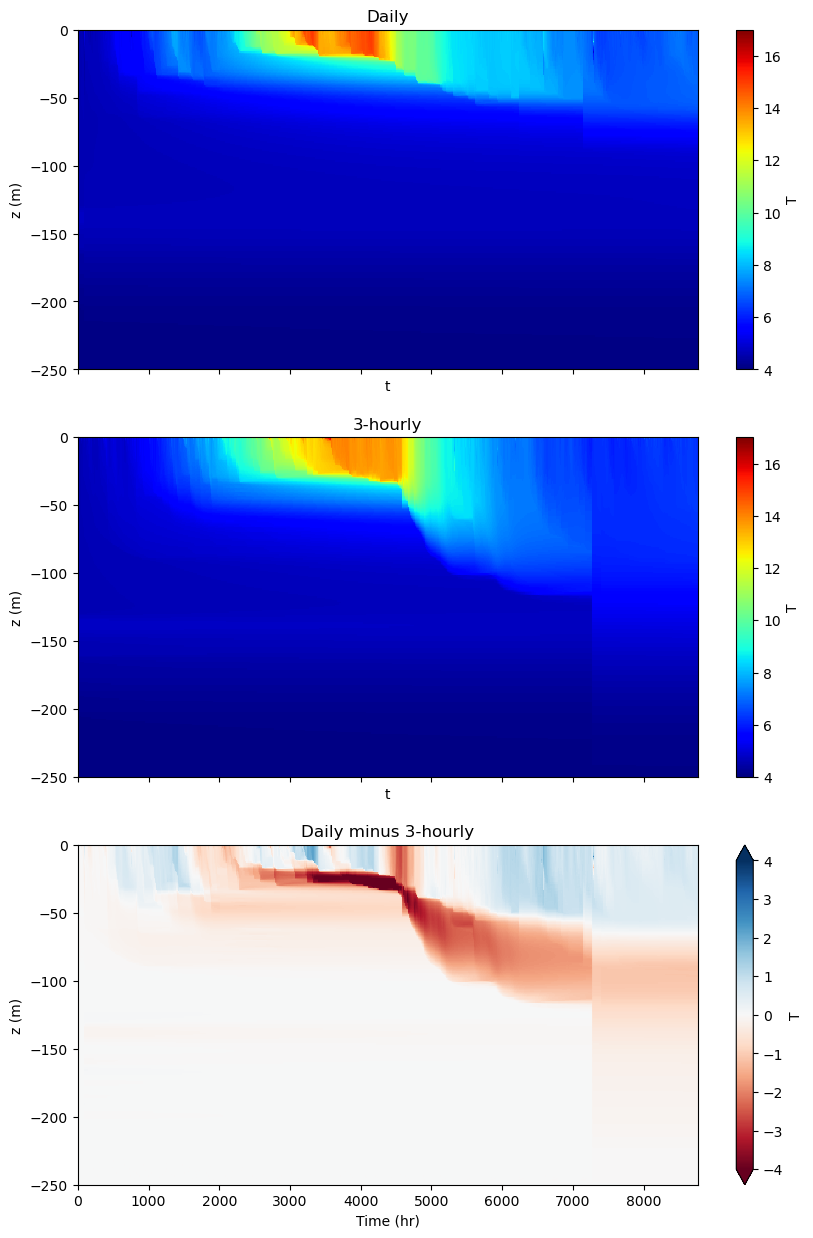

In [60]:
# xrdf['ux'].plot.pcolormesh(x='t',y='z')
fig, axes = plt.subplots(3, 1, figsize=[10,15], sharex=True)

df1 = make_ds('out_kpp_daily')
df1['T'].plot.pcolormesh(ax=axes[0], x='t', y='z', vmin=4, vmax=17, cmap='jet')
axes[0].set_ylabel('z (m)')
axes[0].set_title(r'Daily')
# axes[0].set_xlim([0,4000])

df2 = make_ds('out_kpp')
df2['T'].plot.pcolormesh(ax=axes[1], x='t', y='z', vmin=4, vmax=17, cmap='jet')
axes[1].set_ylabel('z (m)')
axes[1].set_title('3-hourly')
# axes[1].set_xlim([0,4000])

df2_Tinterp = df2['T'].interp(t=df1.t, z=df1.z)
diff = df1['T']-df2_Tinterp
diff.plot.pcolormesh(ax=axes[2], x='t', y='z', vmin=-4, vmax=4, cmap='RdBu')
axes[2].set_ylabel('z (m)')
axes[2].set_xlabel('Time (hr)'); 
axes[2].set_title(r'Daily minus 3-hourly')
# axes[2].set_xlim([0,4000])

Text(0.5, 1.0, '3-hourly minus daily')

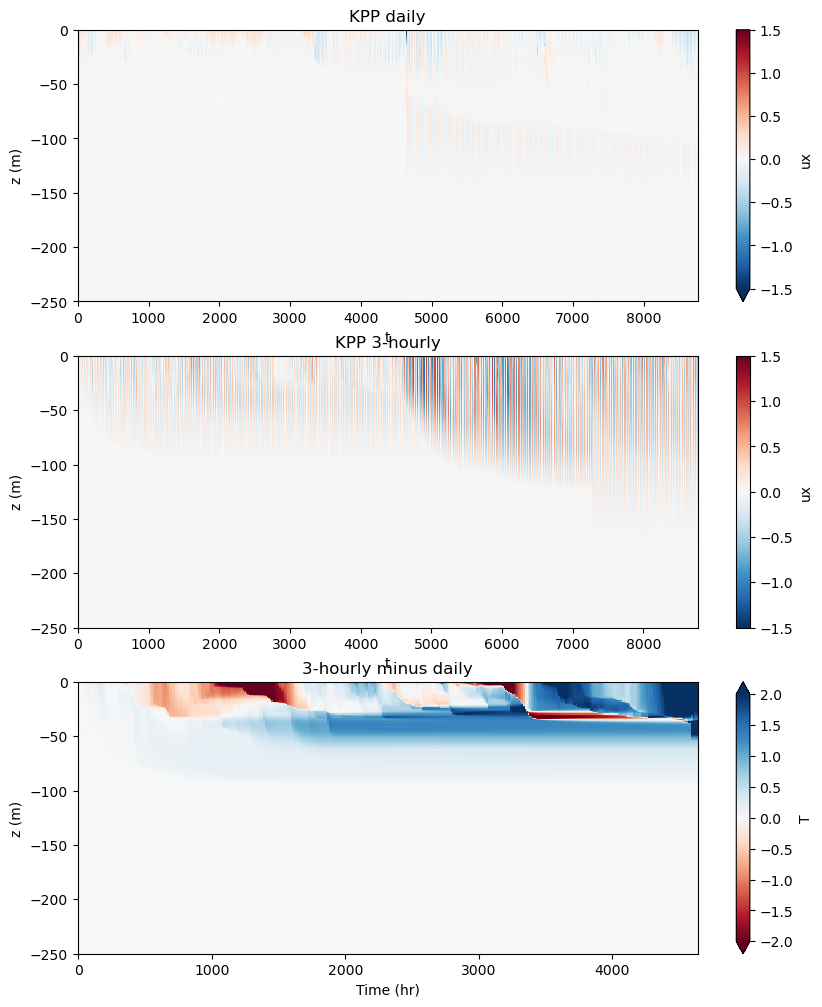

In [159]:
# xrdf['ux'].plot.pcolormesh(x='t',y='z')
fig, axes = plt.subplots(3, 1, figsize=[10,12])

df1 = make_ds('out_kpp_daily')
df1['ux'].plot.pcolormesh(ax=axes[0], x='t', y='z', vmax=1.5, vmin=-1.5, cmap='RdBu_r')
axes[0].set_ylabel('z (m)')
axes[0].set_title('KPP daily')

df2 = make_ds('out_kpp')
df2['ux'].plot.pcolormesh(ax=axes[1], x='t', y='z', vmax=1.5, vmin=-1.5, cmap='RdBu_r')
axes[1].set_ylabel('z (m)')
axes[1].set_title('KPP 3-hourly')

(df2['T']-df1['T']).plot.pcolormesh(ax=axes[2], x='t',y='z', vmin=-2, vmax=2, cmap='RdBu')
axes[2].set_ylabel('z (m)')
axes[2].set_xlabel('Time (hr)'); 
axes[2].set_title(r'3-hourly minus daily')


In [189]:
with open('out_kpp_daily', 'r') as file:
    lines = file.readlines()
    
# Exclude the last two lines
lines_to_keep = lines[:-2]
# Join valid lines into a single string with newline characters
valid_data = "\n".join(lines_to_keep)
df = pd.read_csv(StringIO(valid_data), sep='\s+', header=None, names=['t','z','ux','uy','T','S','nn','nu'])

# By default, reshape uses row-major (C-style) order, meaning it fills the array row by row.
n1 = 731 # number of time steps
n2 = 250 # number of depth
time = df['t'][::n2]/3600. # output is every 12 hrs (from second to hour)
depth = df['z'][:n2] # depth are 1 m apart

ux_2D = np.reshape(df['ux'],(n1,n2))
uy_2D = np.reshape(df['uy'],(n1,n2))
T = np.reshape(df['T'],(n1,n2))
S = np.reshape(df['S'],(n1,n2))

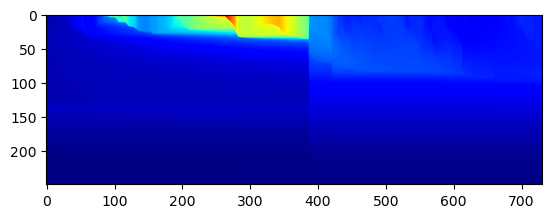

In [193]:
plt.imshow(np.rot90(T), vmin=4, vmax=17, cmap='jet')

### ANNs

In [3]:
def read (filename, n1, n2):
    with open(filename, 'r') as file:
        lines = file.readlines()
        
    # Exclude the last two lines
    lines_to_keep = lines[:-2]
    # Join valid lines into a single string with newline characters
    valid_data = "\n".join(lines_to_keep)
    df = pd.read_csv(StringIO(valid_data), sep='\s+', header=None, 
                     names=['t','z','ux','uy','T','S','nn','nu','taux','tauy','Q'])
    
    # By default, reshape uses row-major (C-style) order, meaning it fills the array row by row.
    time = pd.to_timedelta(df['t'][::n2], unit='s') # from second to hour 
    start_date = pd.Timestamp('2012-03-21') # Add start time
    datetime = start_date + time
    depth = df['z'][:n2] # depth are 1 m apart
    
    ux = np.reshape(df['ux'],(n1,n2))
    uy = np.reshape(df['uy'],(n1,n2))
    T = np.reshape(df['T'],(n1,n2))
    S = np.reshape(df['S'],(n1,n2))
    taux = np.reshape(df['taux'],(n1,n2))[:,0]
    tauy = np.reshape(df['tauy'],(n1,n2))[:,0]
    Q = np.reshape(df['Q'],(n1,n2))[:,0]

    xrdf = xr.Dataset(
        {'ux':(['t','z'], ux),
        'uy':(['t','z'], uy),
        'T':(['t','z'], T),
        'S':(['t','z'], S),
        'taux':(['t'], taux),
        'tauy':(['t'], tauy),
        'Q':(['t'], Q)}, 
        coords={
            't': datetime,
            'z': depth
        })
    return xrdf


def read_ensem (filename, ENSEM=10, n1=361, n2=200):
    ''' Auguments:
        filename: shared filename
        ENSEM: number of ensemble member
        n1: number of time steps
        n2: number of depth points
    '''
    datasets = []
    for i in range(ENSEM):
        filename_ = filename + '%d' %(i+1)
        ds = read(filename_, n1, n2)
        ds = ds.assign_coords(ensem=(i+1))
        datasets.append(ds)       
    ds_ensem = xr.concat(datasets, dim='ensem')       
    return ds_ensem

In [9]:
ENSEM = 100
n1 = 121 # number of time steps
n2 = 200 # number of depth points
filename = '/home/jw8736/test-gotm/2012/03-05/out'
ds = read_ensem(filename, ENSEM, n1, n2)

In [10]:
ds

<xarray.Dataset>
Dimensions:  (ensem: 100, t: 121, z: 200)
Coordinates:
  * t        (t) datetime64[ns] 2012-03-21 2012-03-21T12:00:00 ... 2012-05-20
  * z        (z) float64 -199.5 -198.5 -197.5 -196.5 ... -3.5 -2.5 -1.5 -0.5
  * ensem    (ensem) int64 1 2 3 4 5 6 7 8 9 10 ... 92 93 94 95 96 97 98 99 100
Data variables:
    ux       (ensem, t, z) float64 0.0 0.0 0.0 0.0 ... -0.1948 -0.2106 -0.2261
    uy       (ensem, t, z) float64 0.0 0.0 0.0 0.0 ... 0.1012 0.09708 0.08887
    T        (ensem, t, z) float64 4.083 4.09 4.097 4.104 ... 6.542 6.581 6.61
    S        (ensem, t, z) float64 33.73 33.73 33.73 33.72 ... 32.71 32.71 32.71
    taux     (ensem, t) float64 0.1635 0.002426 0.0851 ... -0.005881 -0.01614
    tauy     (ensem, t) float64 0.08967 -0.1158 -0.0752 ... -0.01658 -0.02031
    Q        (ensem, t) float64 -213.7 -221.8 -156.2 ... -66.64 -65.62 -124.2

Text(0.5, 0, '$t$')

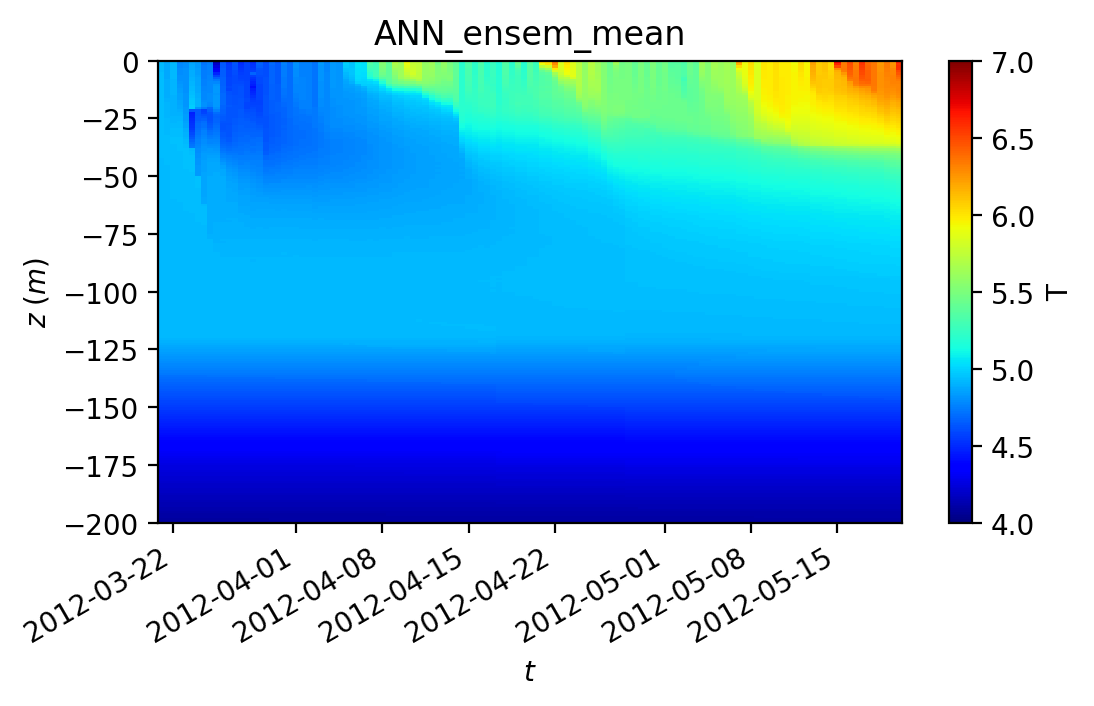

In [177]:
plt.figure(figsize=[6,3], dpi=200)
ds.T.mean(dim='ensem').plot(x='t', cmap='jet', vmin=4, vmax=7)
plt.title('ANN_ensem_mean')
plt.ylabel('$z \; (m)$'); plt.xlabel('$t$')

Text(0.5, 0, '$t$')

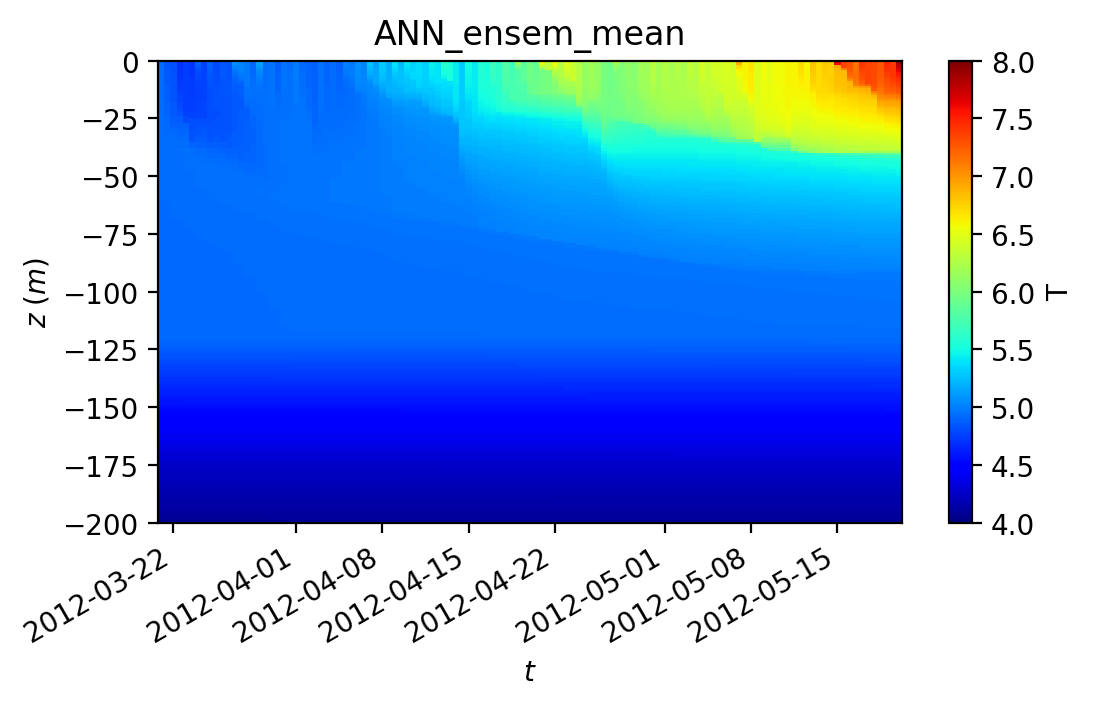

In [198]:
filename = '/home/jw8736/test-gotm/2012/bulk/out'
ds_bulk = read(filename, n1=121, n2=200)

plt.figure(figsize=[6,3], dpi=200)
ds_bulk.T.plot(x='t', cmap='jet', vmin=4, vmax=8)
plt.title('ANN_ensem_mean')
plt.ylabel('$z \; (m)$'); plt.xlabel('$t$')

In [199]:
filename = '/home/jw8736/test-gotm/2012/ann/out'
ds_ann = read(filename, n1=121, n2=200)

plt.figure(figsize=[6,3], dpi=200)
ds_ann.T.plot(x='t', cmap='jet', vmin=4, vmax=8)
plt.title('ANN_ensem_mean')
plt.ylabel('$z \; (m)$'); plt.xlabel('$t$')

ValueError: cannot reshape array of size 72200 into shape (121,200)

Text(0.5, 0, '$t$')

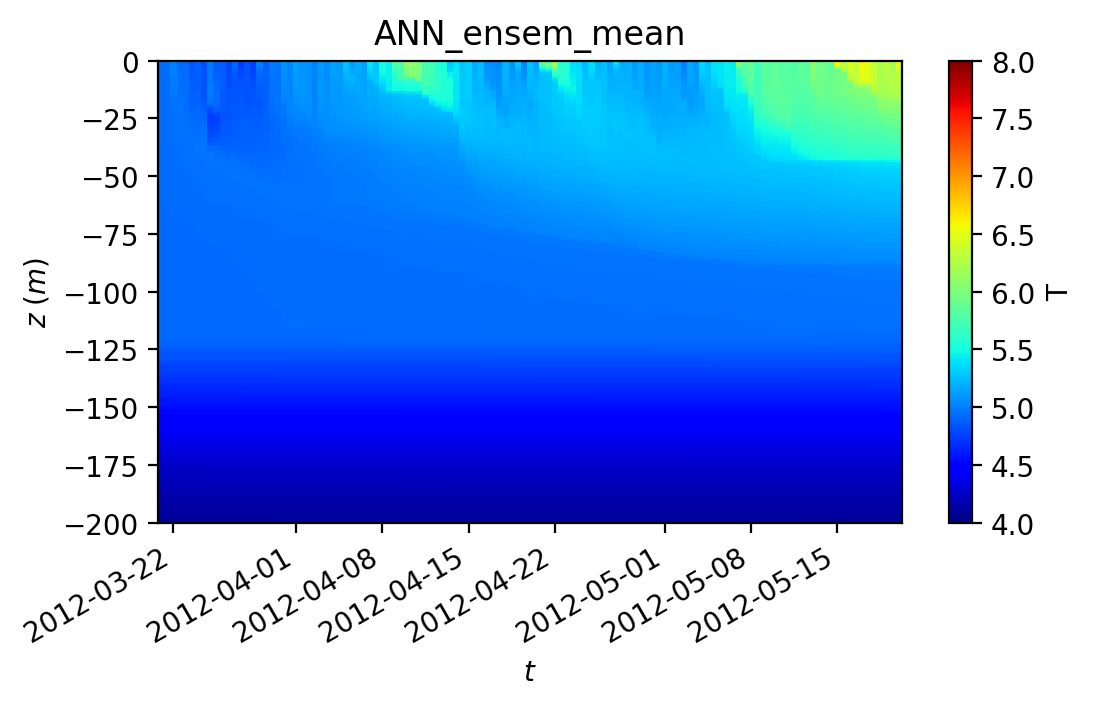

In [193]:
plt.figure(figsize=[6,3], dpi=200)
ds.T.sel(ensem=10).plot(x='t', cmap='jet', vmin=4, vmax=8)
plt.title('ANN_ensem_mean')
plt.ylabel('$z \; (m)$'); plt.xlabel('$t$')

In [14]:
filename = '/home/jw8736/test-gotm/2012/ann/out'
df_ann = read(filename)
filename = '/home/jw8736/test-gotm/2012/bulk/out'
df_bulk = read(filename)

Text(0.5, 0, '$t$')

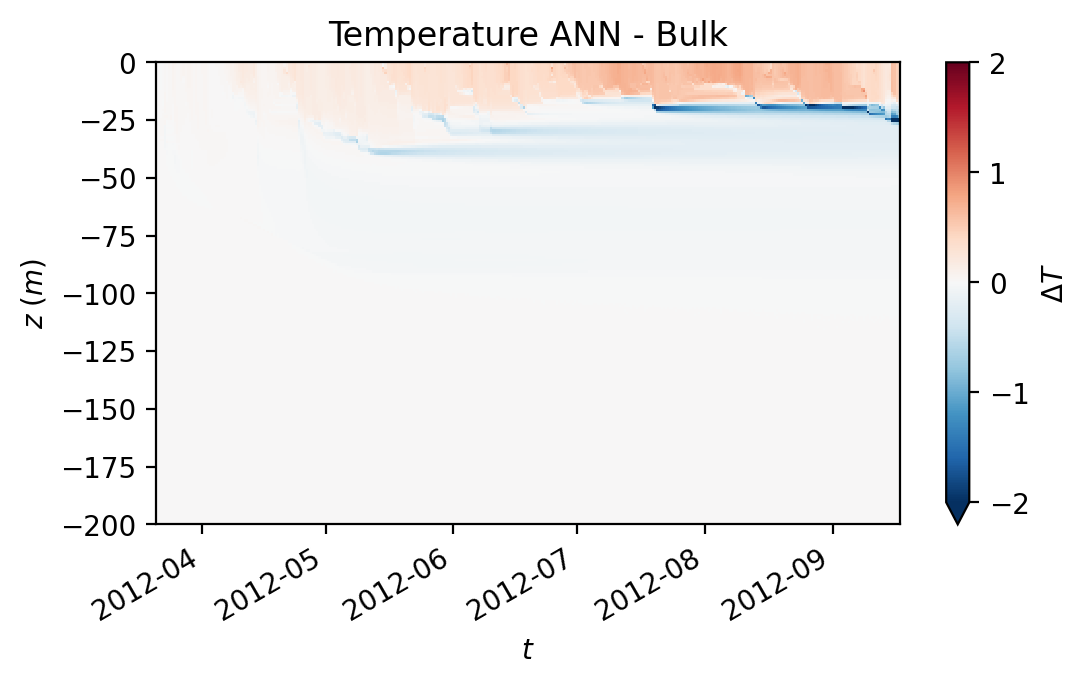

In [32]:
plt.figure(figsize=[6,3], dpi=200)
T_diff = df_ann.T - df_bulk.T
T_diff.plot(cmap='RdBu_r', vmax=2, vmin=-2, x='t', cbar_kwargs={'label':'$\Delta T$'})
plt.title('Temperature ANN - Bulk')
plt.ylabel('$z \; (m)$'); plt.xlabel('$t$')

Text(0.5, 1.0, 'Ux ANN - Bulk')

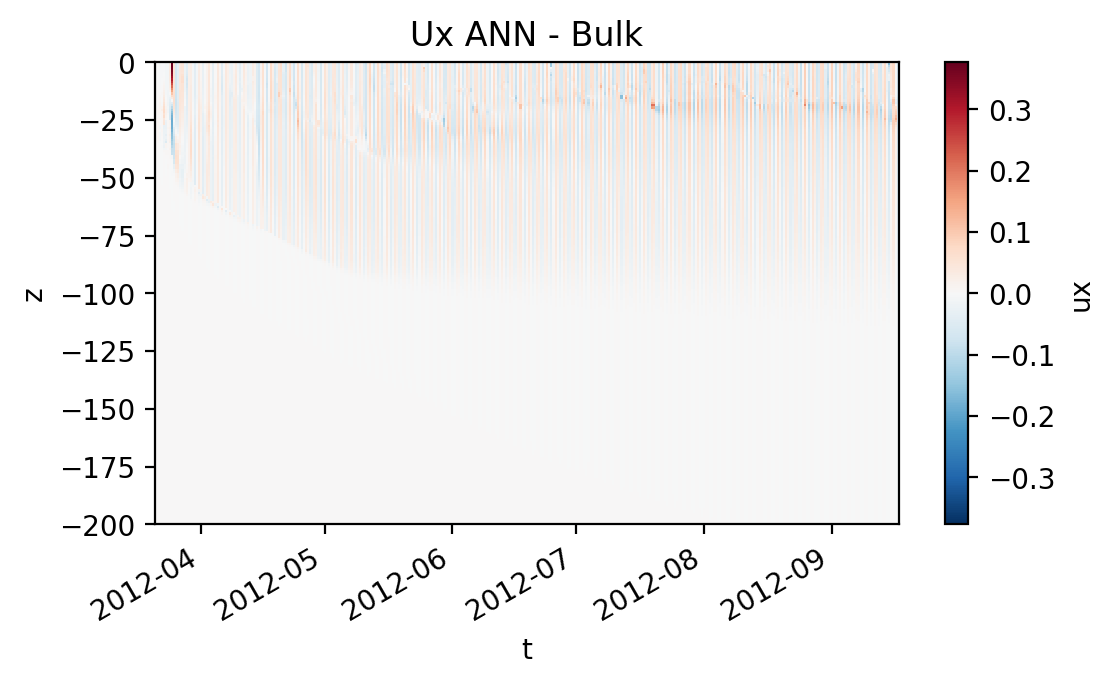

In [17]:
plt.figure(figsize=[6,3], dpi=200)
ux_diff = df_ann.ux - df_bulk.ux
ux_diff.plot(cmap='RdBu_r', x='t')
plt.title('Ux ANN - Bulk')

Text(0.5, 0, '$t$')

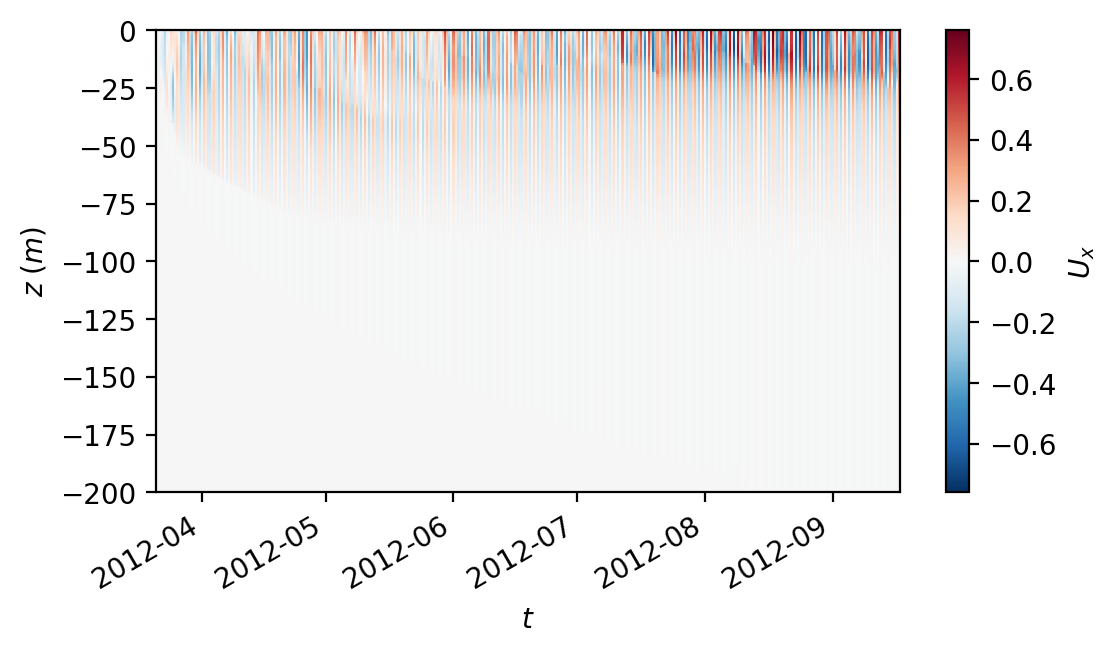

In [36]:
# ux_diff = df_ann.ux.sel(t=slice('2012-03-21','2012-06-21'))
plt.figure(figsize=[6,3], dpi=200)
ux_diff = df_ann.ux
ux_diff.plot(cmap='RdBu_r', x='t', cbar_kwargs={'label':'$U_x$'})
plt.ylabel('$z \; (m)$'); plt.xlabel('$t$')

Text(0, 0.5, '$z \\; (m)$')

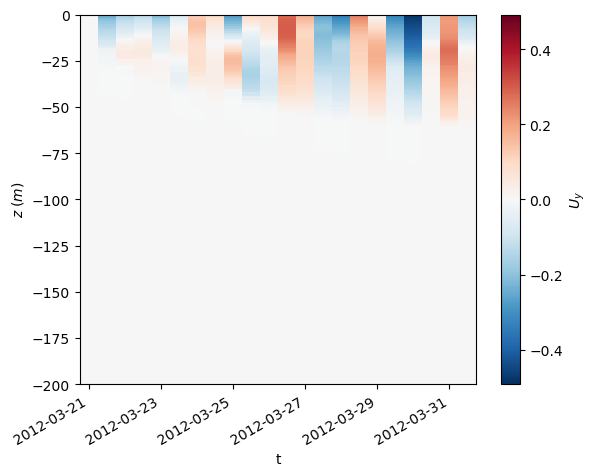

In [27]:
ux_diff = df_ann.uy.sel(t=slice('2012-03-21','2012-03-31'))
ux_diff.plot(cmap='RdBu_r', x='t', cbar_kwargs={'label':'$U_y$'})
plt.ylabel('$z \; (m)$')